# A look at refractoriness for Hodgkin & Huxley action potentials

Sometimes Hodgkin & Huxley are late for the **action**!

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [2]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s

In [5]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [8]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [9]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [10]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [11]:
soma.L = 10 * um
soma.diam =  10 * um

In [12]:
volume = soma(0.5).volume() * um**3

In [13]:
area = soma(0.5).area() * um**2

In [14]:
area

array(314.15926536) * um**2

In [15]:
volume

array(785.3981634) * um**3

### Assign the membrane capacitance "everywhere"

In [16]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [17]:
specific_membrane_capacitance = 1 * uF/cm**2

In [18]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add the Hodgkin-Huxley conductances

In [19]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("hh")

__nrnsec_0x55b25f31b7f0

That's almost too easy!

### Parametize the leak conductance G = 1/R

In [20]:
G = 0.1 * nS  # R = 1/G in our RC circuit

In [21]:
v_rest = -70*mV

In [22]:
tau_m = soma(0.5).cm / soma(0.5).hh.gl

In [23]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [24]:
tau_m

array(31.41592654) * ms

In [25]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.hh.gl = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.hh.el = -54.3

### Inspect our parameters

In [26]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [3.1830988618379074e-05],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x55b25f31b7f0',
 'hoc_internal_name': '__nrnsec_0x55b25f31b7f0',
 'cell': None}

In [27]:
soma.nseg

1

### Add a current injection

In [28]:
stim = h.IClamp(soma(0.5))

In [29]:
stim.delay = 200 * ms  # time to inject current after the start of the simulation 
stim.dur = 1 * ms  # stop injecting current at delay+dur 
stim.amp = 0.15 * nA  # amplitude of current to inject 

### Add a second "test" pulse to query refractoriness

In [30]:
stim2 = h.IClamp(soma(0.5))

In [31]:
stim2.delay = 205 * ms  # time to inject current after the start of the simulation 
stim2.dur = 1 * ms  # stop injecting current at delay+dur 
stim2.amp = 0.6 * nA  # amplitude of current to inject 

## Step 3: Run the simulation

### Define recordings of simulation variables

In [32]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [33]:
# Record hh gating variables
hh_vars = ['h', 'm', 'n', 'gna', 'gk']
hh_recordings = {}
for var in hh_vars:
    ref = getattr(soma(0.5).hh, "_ref_"+var )
    hh_recordings[var] = h.Vector().record(ref) 

In [34]:
hh_recordings

{'h': Vector[2],
 'm': Vector[3],
 'n': Vector[4],
 'gna': Vector[5],
 'gk': Vector[6]}

### Run the simulation

In [35]:
h.finitialize( float(v_rest) )
h.continuerun( float(1000 * ms) )

0.0

## Step 4: Plot the results

(195.0, 220.0, -80.0, 30.0)

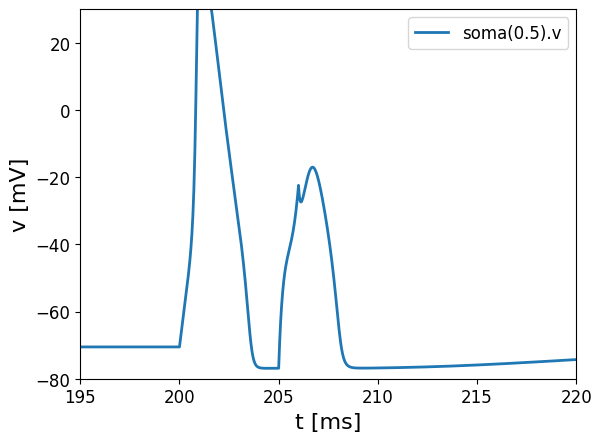

In [36]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([195,220,-80,30])

(195.0, 220.0, 0.0, 1.0)

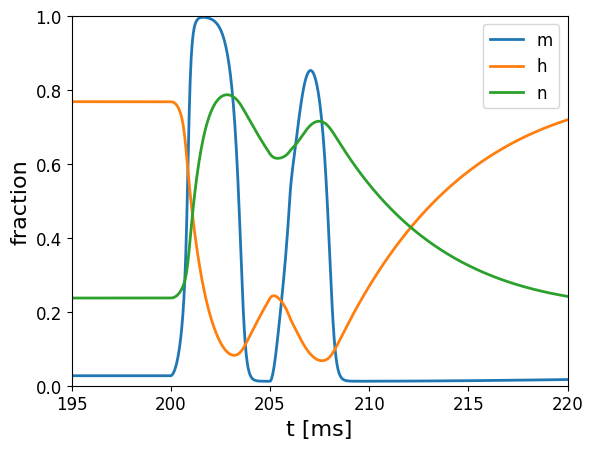

In [37]:
plt.plot(t, hh_recordings['m'], lw=2, label="m")
plt.plot(t, hh_recordings['h'], lw=2, label="h")
plt.plot(t, hh_recordings['n'], lw=2, label="n")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("fraction", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([195,220,0,1])

(195.0, 220.0, 0.0, 0.05)

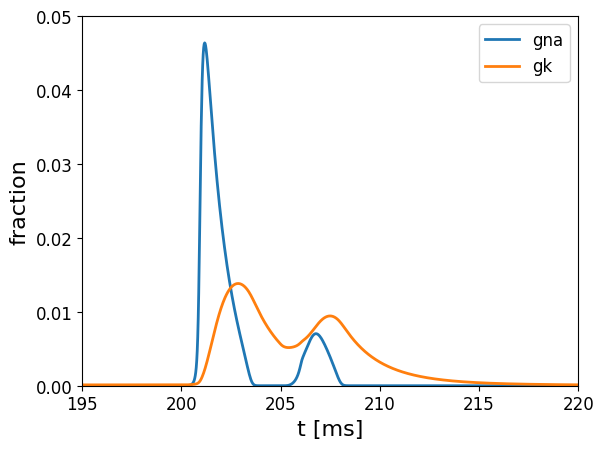

In [38]:
plt.plot(t, hh_recordings['gna'], lw=2, label="gna")
plt.plot(t, hh_recordings['gk'], lw=2, label="gk")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("fraction", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([195,220,0, 0.05])

In [39]:
def find_spikes(v, t):
    """ Returns times of spikes for a voltage trace and time grid"""
    
    # look for upward crossing of 0mV
    v_arr = np.array(v)
    t_arr = np.array(t) 
    # This is tricky & powerful notation! Let's discuss in class!
    return t_arr[1:][(v_arr[1:]>0) & (v_arr[:-1]<0)] 

In [40]:
spike_times = find_spikes(soma_v, t)

In [41]:
spike_times, len(spike_times)

(array([200.825]), 1)

(200.0, 250.0, -80.0, 30.0)

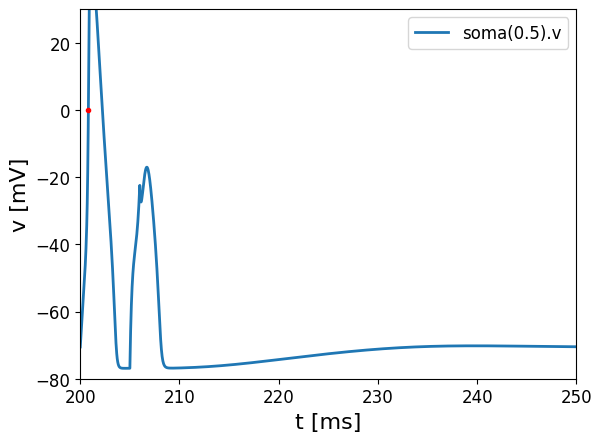

In [42]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot(spike_times, len(spike_times)*[0], 'r.')
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([200,250,-80,30])

In [44]:
def is_second_pulse_causing_spike(stim_amp, delay):
    """
    Apply the second pulse of stim_amp at 200+delay ms 
    and return 1 if it caused a spike, otherwise -1
    (For use with binary search)
    """
    stim2.amp = stim_amp  # amplitude of current to inject in nA
    stim2.delay = 200+delay # delay of injection in ms
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    spike_times = find_spikes(soma_v, t)
    resulting_spikes = spike_times[spike_times>200+delay]
    if len(resulting_spikes)>=1:
        return 1
    else:
        return -1

### Using this function, now we can search for Rheobase 
for a particular delay. Example: delay = 10ms.  We will consider currents up to 0.6nA, because anything bigger than that is driving the membrane close to 0.0mV even without spiking (as we saw above).

In [57]:
stim_amp = np.arange(0,0.6,0.01)
is_spiking = [is_second_pulse_causing_spike(x, delay = 10) for x in stim_amp]

(0.0, 0.15, -1.1, 1.1)

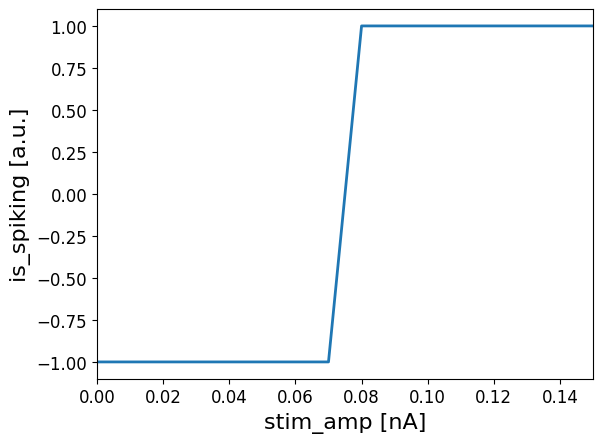

In [62]:
plt.plot(stim_amp, is_spiking, lw=2)
plt.xlabel("stim_amp [nA]", size=16)
plt.ylabel("is_spiking [a.u.]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([0, 0.15, -1.1, 1.1])

### Now let's search for the zero-crossing of this function for each delay

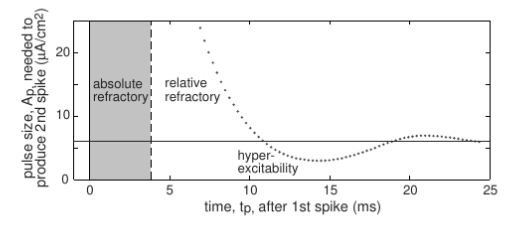

To see if we can reproduce this figure from Izhikevich, 2006

### Binary search will do the trick to find the zero-crossing
... and scipy.optimize.bisect is can do this for us.  

In [47]:
import scipy.optimize

In [63]:
# This will find the zero crossing at delay=10.0123
# within the range 0.0 <= stim_amp <= 0.6
# It will run at most maxiter=50 iterations
# It will stop when it has found the root to absolute error of xtol=1e-3
scipy.optimize.bisect(is_second_pulse_causing_spike, 0.0, 0.6, args=(10.0123,), xtol=1e-3, maxiter=50)

0.0791015625

In [123]:
def find_second_pulse_rheobase(delay, xtol=1e-3):
    # In the absolute refractory region, no spike will be produced at stim_amp=0.6nA
    if is_second_pulse_causing_spike(0.6, delay) < 0:
        # Let's return a negative rheobase to indicate absolute refractory region 
        return -1.0
    rheobase = scipy.optimize.bisect(is_second_pulse_causing_spike, 0.0, 0.6, args=(delay,), xtol=xtol, maxiter=50)
    return rheobase

In [124]:
find_second_pulse_rheobase(10.0123)

0.0791015625

In [67]:
find_second_pulse_rheobase(4)

-1.0

## Now it's your turn!

### **Question 1** 
By using the two test pulse approach (up to ~0.6nA), map out the approximate absolute and relative refractory periods.
<br>
<br>
**Note:** A current above 0.6 nA can drive large passive voltage deflections, but if $g_{Na}$ remains significantly lower that during spike, it is not a regenerative "spike"/AP event.



In [102]:
# Delays to assess rheobase at
delay = np.array([1,2,4,6,8,10,12,14,16,18,20,25,30,40])
rheobase = np.array([find_second_pulse_rheobase(x) for x in delay])

In [103]:
rheobase

array([-1.        , -1.        , -1.        ,  0.30058594,  0.13183594,
        0.07910156,  0.05683594,  0.04394531,  0.03691406,  0.03105469,
        0.02753906,  0.02285156,  0.02167969,  0.02285156])

In [104]:
# Find index in array where rheobase is first positive
idx_relative_ref = np.searchsorted(rheobase>0, True)

In [105]:
idx_relative_ref 

3

In [106]:
abs_refractory_period = delay[idx_relative_ref]

In [107]:
abs_refractory_period

6

(0.0, 40.0, -0.1, 0.35)

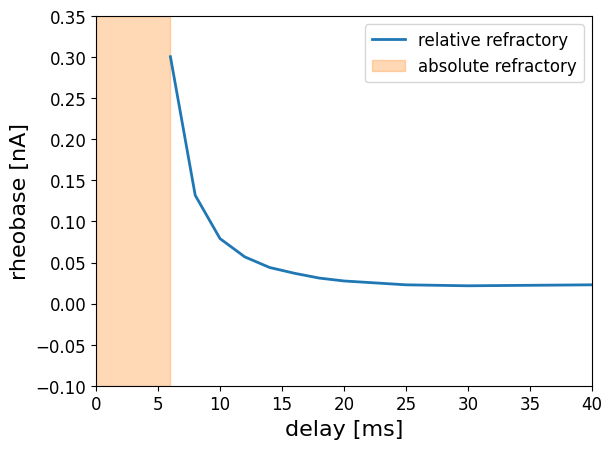

In [109]:
plt.plot(delay[idx_relative_ref:], rheobase[idx_relative_ref:], lw=2, label="relative refractory")
plt.fill_between([0,abs_refractory_period], 0.35, -0.1, color="C1", alpha=0.3, label="absolute refractory")
plt.xlabel("delay [ms]", size=16)
plt.ylabel("rheobase [nA]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(fontsize=12)
plt.axis([0, 40, -0.1, 0.35])

### **Bonus Exercise** 

Near to Rheobase, the latency of the AP is strongly dependent on stimulus current.
Plot the action potential voltage trajectory for different stimulus currents slightly above rheobase to show this dependence. 


In [106]:
stim2.amp = 0.0 * nA  # amplitude of current to inject 

In [172]:
stim.delay = 200 * ms  # time to inject current after the start of the simulation 
stim.dur = 1 * ms  # stop injecting current at delay+dur 
stim.amp = 0.15 * nA 

In [141]:
h.finitialize( float(v_rest) )
h.continuerun( float(2000 * ms) )

0.0

In [126]:
# What is the rheobase for large delays? (e.g. forgot about the first spike)
find_second_pulse_rheobase(500, xtol=1e-5)

0.0235748291015625

## Plot the results

(200.0, 215.0, -80.0, 50.0)

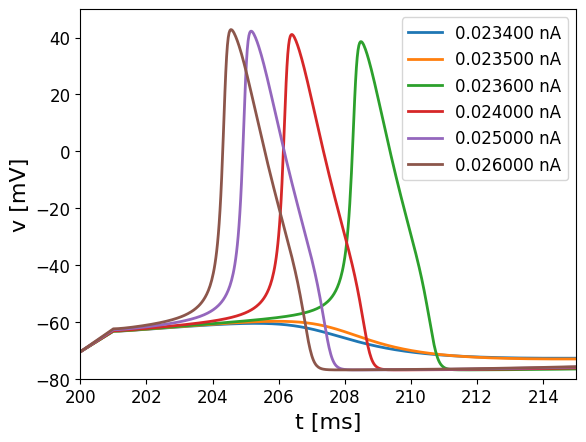

In [129]:
for amp in [0.0234, 0.0235, 0.0236, 0.024, 0.025, 0.026]:
    stim.amp = amp
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    plt.plot(t, soma_v, lw=2, label="%.6f nA" % amp)
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([200,215,-80,50])